<a href="https://colab.research.google.com/github/anirbanghoshsbi/.github.io/blob/master/kalman/signal_kalman_nifty.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [33]:
!pip install pykalman
!pip install yfinance
!pip install pandas-ta==0.2.45b

In [34]:
#Importing dependencies#
from pykalman import KalmanFilter
import numpy as np
import pylab as pl
import pandas as pd
import yfinance as yf
from scipy import poly1d
from datetime import datetime
import pandas_ta as ta
import matplotlib.pyplot as plt
%matplotlib inline

In [35]:
pd.options.mode.chained_assignment = None

In [36]:
#ticker = pd.read_csv('https://raw.githubusercontent.com/anirbanghoshsbi/data/main/ind_niftybanklist.csv')

In [37]:
ticker = pd.read_csv('https://raw.githubusercontent.com/anirbanghoshsbi/data/main/ind_nifty50list.csv')
START = "2013-01-01"

In [38]:
nifty=yf.download('^nsebank',start=START)

[*********************100%***********************]  1 of 1 completed


In [39]:
lst=[]
for i in range(len(ticker)):
  
  dfi = yf.download(str(ticker.Symbol.iloc[i])+'.ns', start=START)
  df = dfi[['Adj Close']]
  f = KalmanFilter(transition_matrices = [1],
                    observation_matrices = [1],
                    initial_state_mean = 0,
                    initial_state_covariance = 1,
                    observation_covariance = 1,
                    transition_covariance = 0.0001)
  mean, cov = f.filter(df['Adj Close'].values)
  mean, std = mean.squeeze(), np.std(cov.squeeze())
  var = 'kalman'
  df[var]=df['Adj Close'].values - mean
  
  lst.append(df)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

In [40]:
nlst=[]
for i in range(len(ticker)):
  nlst.append(lst[i].kalman)
  

In [41]:
df_kalman = pd.DataFrame(nlst).T

In [42]:
namelist =[]
for i in range(1,len(ticker)+1):
  namelist.append('kalman_'+str(i))
  
df_kalman.columns = namelist

In [43]:
def macd_calc(df):
  columns=df.columns.tolist()
  for var in columns:
    macd='macd'+var
    macd_s='macd'+'signal'+var
    macd_h='hist'+ var
    df[macd]=df[var].ewm(span=26, adjust=False).mean()-df[var].ewm(span=50, adjust=False).mean()
    df[macd_s]=df[macd].ewm(span=18,adjust=False).mean()
    df[macd_h]=df[macd]-df[macd_s]
  return df

In [44]:
final_kalman=macd_calc(df_kalman)

In [45]:
final_kalman.tail(2)

,kalman_1,kalman_2,kalman_3,kalman_4,kalman_5,kalman_6,kalman_7,kalman_8,kalman_9,kalman_10,kalman_11,kalman_12,kalman_13,kalman_14,kalman_15,kalman_16,kalman_17,kalman_18,kalman_19,kalman_20,kalman_21,kalman_22,kalman_23,kalman_24,kalman_25,kalman_26,kalman_27,kalman_28,kalman_29,kalman_30,kalman_31,kalman_32,kalman_33,kalman_34,kalman_35,kalman_36,kalman_37,kalman_38,kalman_39,kalman_40,...,histkalman_37,macdkalman_38,macdsignalkalman_38,histkalman_38,macdkalman_39,macdsignalkalman_39,histkalman_39,macdkalman_40,macdsignalkalman_40,histkalman_40,macdkalman_41,macdsignalkalman_41,histkalman_41,macdkalman_42,macdsignalkalman_42,histkalman_42,macdkalman_43,macdsignalkalman_43,histkalman_43,macdkalman_44,macdsignalkalman_44,histkalman_44,macdkalman_45,macdsignalkalman_45,histkalman_45,macdkalman_46,macdsignalkalman_46,histkalman_46,macdkalman_47,macdsignalkalman_47,histkalman_47,macdkalman_48,macdsignalkalman_48,histkalman_48,macdkalman_49,macdsignalkalman_49,histkalman_49,macdkalman_50,macdsignalkalman_50,histkalman_50
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2021-11-03,30.390471,301.423522,22.404604,-2.585736,1290.863798,4033.680225,0.685708,101.308726,-28.606235,26.011941,21.217278,729.982706,-67.540485,-77.937382,365.621553,138.022772,89.871395,9.061935,-230.841336,87.353098,-20.083793,317.226744,138.481554,10.069724,25.555927,167.469000,215.888650,75.332508,214.488128,364.250731,69.767857,641.620084,23.606478,672.440328,32.154537,15.740194,267.873379,126.816505,1614.125142,125.052168,...,-23.759473,-12.852538,-3.536229,-9.316309,-257.963422,-237.477321,-20.486101,9.623709,5.505251,4.118457,-0.92083,3.347821,-4.268651,-71.980299,-24.404497,-47.575801,-14.405120,-10.825377,-3.579742,33.989789,26.069301,7.920489,-42.022154,-40.667303,-1.354851,9.302193,13.380990,-4.078797,69.673181,76.291763,-6.618582,-16.313939,-19.317214,3.003275,-107.335085,-127.069807,19.734723,-5.417656,-0.911484,-4.506172
2021-11-04,34.543307,287.137848,24.508328,57.783726,1286.781580,4077.254093,5.480633,102.280792,-5.797965,23.822510,21.946708,789.943577,-72.313723,61.197575,367.973302,143.332264,101.352786,13.031009,-192.853090,80.840658,-8.498383,317.832537,133.291917,14.028740,27.380738,176.841743,219.878792,72.998885,231.610366,379.882812,92.686323,648.254943,23.767604,816.335662,31.884101,16.672638,280.306266,128.475264,1664.049672,126.580011,...,-26.303228,-12.950908,-4.527248,-8.423660,-232.384865,-236.941273,4.556409,10.166453,5.995904,4.170549,-1.91530,2.793808,-4.709109,-73.519705,-29.574519,-43.945185,-14.240575,-11.184872,-3.055704,33.577202,26.859606,6.717596,-41.767219,-40.783084,-0.984136,8.634041,12.881311,-4.247270,66.942972,75.307680,-8.364708,-15.568951,-18.922660,3.353709,-92.881703,-123.471060,30.589356,-6.179383,-1.466000,-4.713384


In [46]:
features = final_kalman.columns.tolist()

In [47]:
feats_set1=[feats for feats in features if feats.startswith('hist')]

In [48]:
final_dataframe=final_kalman[feats_set1]

In [49]:
solution=np.sign(final_dataframe)

In [50]:
solution['final']=solution.sum(axis=1)

In [51]:
solution.tail(2)

,histkalman_1,histkalman_2,histkalman_3,histkalman_4,histkalman_5,histkalman_6,histkalman_7,histkalman_8,histkalman_9,histkalman_10,histkalman_11,histkalman_12,histkalman_13,histkalman_14,histkalman_15,histkalman_16,histkalman_17,histkalman_18,histkalman_19,histkalman_20,histkalman_21,histkalman_22,histkalman_23,histkalman_24,histkalman_25,histkalman_26,histkalman_27,histkalman_28,histkalman_29,histkalman_30,histkalman_31,histkalman_32,histkalman_33,histkalman_34,histkalman_35,histkalman_36,histkalman_37,histkalman_38,histkalman_39,histkalman_40,histkalman_41,histkalman_42,histkalman_43,histkalman_44,histkalman_45,histkalman_46,histkalman_47,histkalman_48,histkalman_49,histkalman_50,final
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2021-11-03,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,1.0,1.0,-1.0,-30.0
2021-11-04,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,1.0,1.0,-1.0,-28.0


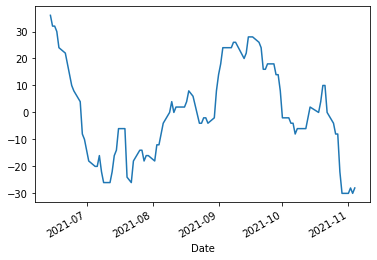

In [52]:
solution.final[-100:].plot()

In [53]:
l=700

In [54]:
nifty=nifty[-l:]
solution=solution[-l:]

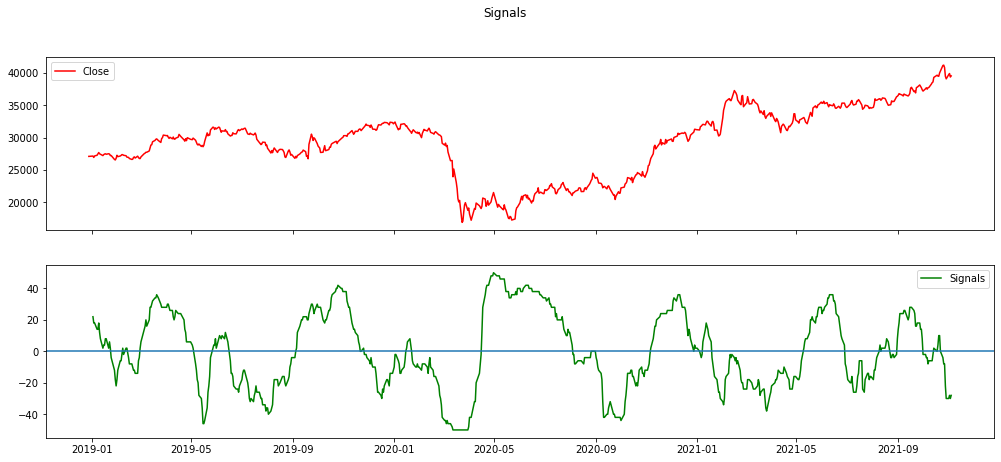

In [55]:
fig, ax = plt.subplots(2,1,figsize=(17,7),sharex=True)
ax[0].plot(nifty.loc[:, :].index, nifty.loc[:, 'Close'],'r', label='Close')
ax[1].plot(solution.loc[:, :].index, solution.loc[:, 'final'],'g', label='Signals')
#ax[1].plot(nifty.iloc[:, :].index, nifty.loc[:, 'Close'], label='Nifty')
plt.suptitle('Signals')
ax[0].legend()
ax[1].legend()
ax[1].axhline(y=0)
plt.show()

In [56]:
solution['signals']=np.where(solution['final']>0,1,-1)

In [57]:
if solution['signals'].iloc[-1]!=solution['signals'].iloc[-2]:
  var= solution['signals'].iloc[-1]
  print(f'signal changed to : {var}')
else :
  var= solution['signals'].iloc[-1]
  print(f'signal unchanged (1:stay long , -1: stay short) : {var}')

signal unchanged (1:stay long , -1: stay short) : -1


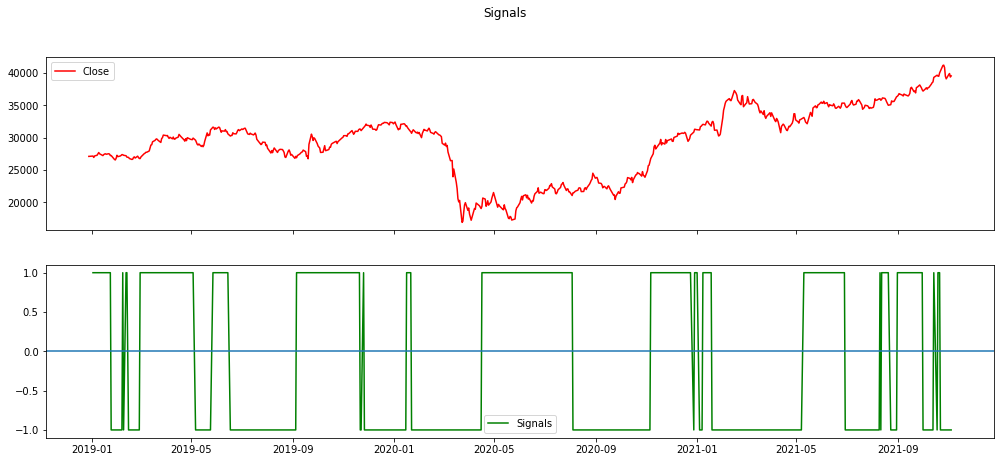

In [58]:
fig, ax = plt.subplots(2,1,figsize=(17,7),sharex=True)
ax[0].plot(nifty.loc[:, :].index, nifty.loc[:, 'Close'],'r', label='Close')
ax[1].plot(solution.loc[:, :].index, solution.loc[:, 'signals'],'g', label='Signals')
#ax[1].plot(nifty.iloc[:, :].index, nifty.loc[:, 'Close'], label='Nifty')
plt.suptitle('Signals')
ax[0].legend()
ax[1].legend()
ax[1].axhline(y=0)
plt.show()